In [37]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib          import cm
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

In [15]:
file = 'data/MC.dat'
data = np.loadtxt(file, comments='#')
X = data[:,0]
YObs = data[:,1]
print(X,YObs)

[0. 1. 2. 3. 4. 5.] [ 8.       6.4      3.14159  1.5707   0.      -1.5    ]


# Modelo de Ajuste
Definimos un modelo matemático para ajustar los datos. La función depende de la variable $x$ y de dos parámetros de ajuste $m$ y $b$.
$$Y_{fit} = mx + b$$

In [16]:
def Model(x,m,b):
    return m*x + b

m1, b1 = -1,4
m2, b2 = -2,7

Xtest = np.linspace(0., 6., 30)
Y1fit = Model(Xtest, m1, b1)
Y2fit = Model(Xtest, m2, b2)

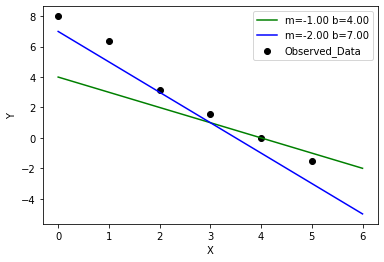

In [29]:
plt.scatter(X, YObs, c='k' ,label="Observed_Data")
plt.plot(Xtest, Y1fit, c='g', label=r"m=%.2f b=%.2f" %(m1, b1))
plt.plot(Xtest, Y2fit, c='b', label=r"m=%.2f b=%.2f" %(m2, b2))
plt.legend(loc=0)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

## Función de costo
Observación: El modelo $model(m_{2},b_{2})$ describe mejor los datos que el modelo $model(m1,b1)$. Para cuantificar el nivel de acuerdo entre los datos observados y el modelo, usamos una función de costo:

$$\chi^2(m,b) = \sum_{i=0}^{N} \frac{(Y_{Obs,i} - Y_{fit})^2}{2\sigma^2} $$

$$\chi^2(m,b) = \sum_{i=0}^{N} \frac{(Y_{Obs,i} - (mX_{i} + b))^2}{2\sigma^2} $$

In [22]:
def Chi2(m,b):
    Y_fit = Model(X,m,b)
    chi2 = 0.
    sigma = 1.
    
    for i in range(len(X)):
        chi2 += (YObs[i] - Y_fit[i])**2/(2.*sigma**2)
    return chi2

In [23]:
Model = np.vectorize(Model)
Chi2 = np.vectorize(Chi2)

In [24]:
m_ = np.arange(-5, 0.,0.25)
b_ = np.arange(0.,10, 0.25)
m_, b_ = np.meshgrid(m_,b_)
z = Chi2(m_,b_)

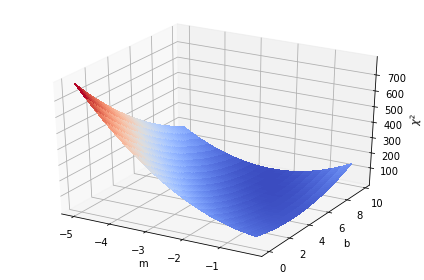

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(m_, b_, z, cmap=cm.coolwarm ,linewidth=0, antialiased=False)
ax.set_xlabel("m")
ax.set_ylabel("b")
ax.set_zlabel(r"$\chi^2$")
plt.tight_layout()

# Metropolis Hastings algorithm
Hacemos una comparación $(\alpha)$ para decidir si damos el paso de $x_{0}$ a $x_{n}$
$$\alpha = \frac{\pi(x_{n})}{\pi(x_{0})}$$
Generamos $x_{n} = x_{0} \Delta r (-1,1)$, donde $r$ es un número aleatorio entre -1 y 1. Para nuestro problema de dos parámetros tenemos: $m_{n} = m_{0} \Delta r(-1,1)$, $b_{n} = b_{0} \Delta r(-1,1)$

$$\alpha ) \frac{exp(-\chi^2(m_{n}, b_{n}))}{exp(-\chi^2(m_{0}, b_{0}))}$$

In [33]:
def Metropolis(m0_, b0_, WidthSteps, NSteps, burned):
    mcmc_steps = []
    burn_steps = 3000.
    for i in range(NSteps):
        P0 = np.exp(-Chi2(m0_, b0_))
        mn_ = m0_ + WidthSteps*2*(np.random.rand() - 0.5)
        bn_ = b0_ + WidthSteps*2*(np.random.rand() - 0.5)
        
        Pn = np.exp(-Chi2(mn_, bn_))
        alpha = Pn/P0
        
        if(burned):
            beta = np.random.rand()
            if(np.minum(alpha,1) >= beta):
                #Cambio de lugar
                m0_ = mn_
                b0_ = bn_
            if(i >= burn_steps):
                mcmc_steps.append([m0_, b0_])
        else:
            if(alpha >= 1.0): #Aceptamos el paso
                mcmc_steps.append([mn_, bn_])
                m0_ = mn_
                b0_ = bn_
            else:
                beta = np.random.rand()
                if(alpha >= beta): #Acepto el paso
                    mcmc_steps.append([mn_, bn_])
                    m0_ = mn_
                    b0_ = bn_
                else: #No se acepta el paso
                    mcmc_steps.append([m0_, b0_])
    mcmc_steps = np.array(mcmc_steps)
    return mcmc_steps

In [40]:
mcmc = Metropolis(-3, 5, 0.05, 50000, False)

M = mcmc[:,0]
B = mcmc[:, 1]

Text(0, 0.5, '$b$')

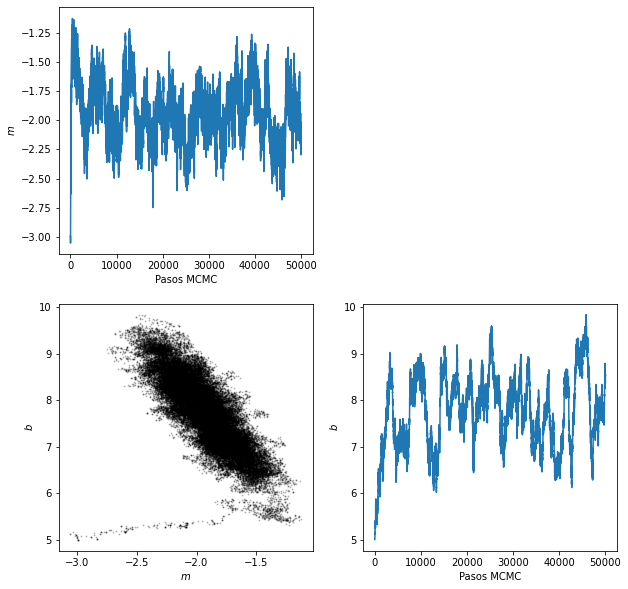

In [41]:
fig = plt.figure( figsize=(10,10))

ax1 = fig.add_subplot(2,2,1)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.plot(M)
ax1.set_xlabel("Pasos MCMC")
ax1.set_ylabel(r'$m$')

ax3.scatter(M, B, c='k', s=1, alpha=0.2)
ax3.set_xlabel(r'$m$')
ax3.set_ylabel(r'$b$')

ax4.plot(B)
ax4.set_xlabel("Pasos MCMC")
ax4.set_ylabel(r'$b$')

Text(0.5, 0, '$b$')

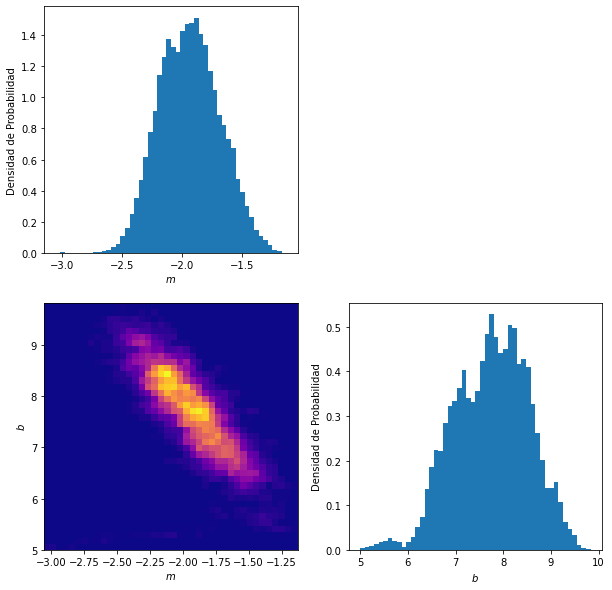

In [43]:
fig = plt.figure( figsize=(10,10))

ax1 = fig.add_subplot(2,2,1)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.hist(M, 50, density=True)
ax1.set_ylabel('Densidad de Probabilidad')
ax1.set_xlabel(r'$m$')

ax3.hist2d(M, B, bins=40, density=False, cmap='plasma')
ax3.set_xlabel(r'$m$')
ax3.set_ylabel(r'$b$')

ax4.hist(B, 50, density=True)
ax4.set_ylabel('Densidad de Probabilidad')
ax4.set_xlabel(r'$b$')

Sin quemado de puntos, no quito los datos basura y no 
me queda una distribución gaussiana

In [50]:
mean_ = []

for i in range(2):
    mean = np.percentile(mcmc[:, i], 50)
    sigma1 = np.percentile(mcmc[:, i], 16)
    sigma2 = np.percentile(mcmc[:,i], 84)
    mean_.append(mean)
    print(mean, sigma2-mean, mean-sigma1)

-1.9391450218345094 0.26738400358318826 0.2544372664648
7.789897154032504 0.7424089498339104 0.8656634578299816


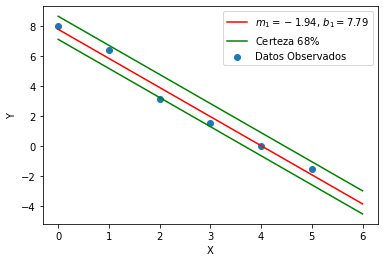

In [52]:
#¿Como reportamos los resultados?
plt.scatter(X, YObs, label="Datos Observados")
plt.xlabel("X")
plt.ylabel("Y")

m_estimated = mean_[0]
b_estimated = mean_[1]

Xtest = np.linspace(0.,6.,30)
Yfit = Model(Xtest, m_estimated, b_estimated)

YfitUp = Model(Xtest, m_estimated, b_estimated+0.87)
YfitDown = Model(Xtest, m_estimated, b_estimated-0.67)

plt.plot(Xtest, Yfit, c='r', label=r"$m_1= {:.2f}$, $b_1={:.2f}$".format(m_estimated, b_estimated))
plt.plot(Xtest, YfitUp, c='g')
plt.plot(Xtest, YfitDown, c='g', label=r'Certeza $68\%$')

plt.legend(loc=0)
plt.show()

#En verde esta la banda de confianza a un sigma. El modelo predice
#todos los puntos a un sigma.